In [1279]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [1280]:
df = pd.read_csv(
    '/Users/maria/Documents/spiced/spiced_projects/week7/data/ECA_blended_custom/TG_STAID002759.txt', 
    skiprows=19, 
    skipinitialspace=True,
)

In [1281]:
df

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0
...,...,...,...,...
53352,111448,20220127,44,0
53353,111448,20220128,49,0
53354,111448,20220129,58,0
53355,111448,20220130,58,0


In [1282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53357 entries, 0 to 53356
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SOUID   53357 non-null  int64
 1   DATE    53357 non-null  int64
 2   TG      53357 non-null  int64
 3   Q_TG    53357 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [1283]:
df.describe()

,SOUID,DATE,TG,Q_TG
count,53357.000000,5.335700e+04,53357.000000,53357.000000
mean,119357.653541,1.948610e+07,57.050415,0.032910
std,8023.826001,4.217116e+05,614.099351,0.543108
min,111448.000000,1.876010e+07,-9999.000000,0.000000
25%,111448.000000,1.912071e+07,33.000000,0.000000
50%,111448.000000,1.949012e+07,94.000000,0.000000
75%,127488.000000,1.985072e+07,157.000000,0.000000
max,128124.000000,2.022013e+07,305.000000,9.000000


In [1284]:
df.drop(['SOUID'], axis=1, inplace=True)

In [1285]:
df['DATE'] = df['DATE'].astype(str)
df.set_index(pd.to_datetime(df['DATE']), inplace= True)
df.drop(['DATE'], axis=1, inplace=True)

In [1286]:
df['T'] = df['TG']*0.1
df.drop(['TG'], axis=1, inplace=True)

In [1287]:
df

,Q_TG,T
DATE,,
1876-01-01,0,2.2
1876-01-02,0,2.5
1876-01-03,0,0.3
1876-01-04,0,-5.8
1876-01-05,0,-9.8
...,...,...
2022-01-27,0,4.4
2022-01-28,0,4.9
2022-01-29,0,5.8


# Imputation

In [1288]:
# Quality coloumn contains info for missing values
df['Q_TG'].value_counts()

0    53161
9      195
1        1
Name: Q_TG, dtype: int64

In [1289]:
missing_values = df[df['Q_TG']==9]
missing_values.index 

DatetimeIndex(['1945-04-25', '1945-04-26', '1945-04-27', '1945-04-28',
               '1945-04-29', '1945-04-30', '1945-05-01', '1945-05-02',
               '1945-05-03', '1945-05-04',
               ...
               '1945-10-27', '1945-10-28', '1945-10-29', '1945-10-30',
               '1945-10-31', '1945-11-01', '1945-11-02', '1945-11-03',
               '1945-11-04', '1945-11-05'],
              dtype='datetime64[ns]', name='DATE', length=195, freq=None)

The 195 missing values are the days between 25.04.1945 and 05.11.1945. 

To impute them, I take the mean temperatures from 2 years before and two years after:

In [1290]:
before = df.loc['1943-04-25':'1945-04-24']
after = df.loc['1945-11-06':'1947-11-05']
before = before.groupby([before.index.month, before.index.day]).mean()
after = after.groupby([after.index.month, after.index.day]).mean()

In [1291]:
for date in missing_values.index:
    df.loc[date,'T'] = round((before.loc[(date.month,date.day),'T']+ 
                              after.loc[(date.month,date.day),'T'])/2,1)

In [1292]:
# Quality coloumn is not needed any more
df.drop(['Q_TG'], axis=1, inplace=True)

# Train - Test Split

In [1293]:
# TODO try with 10 or 20 years test size
df_train = pd.DataFrame.copy(df.loc[:'2016-12-31'])
df_test = pd.DataFrame.copy(df.loc['2017-01-01':])

# Visualization

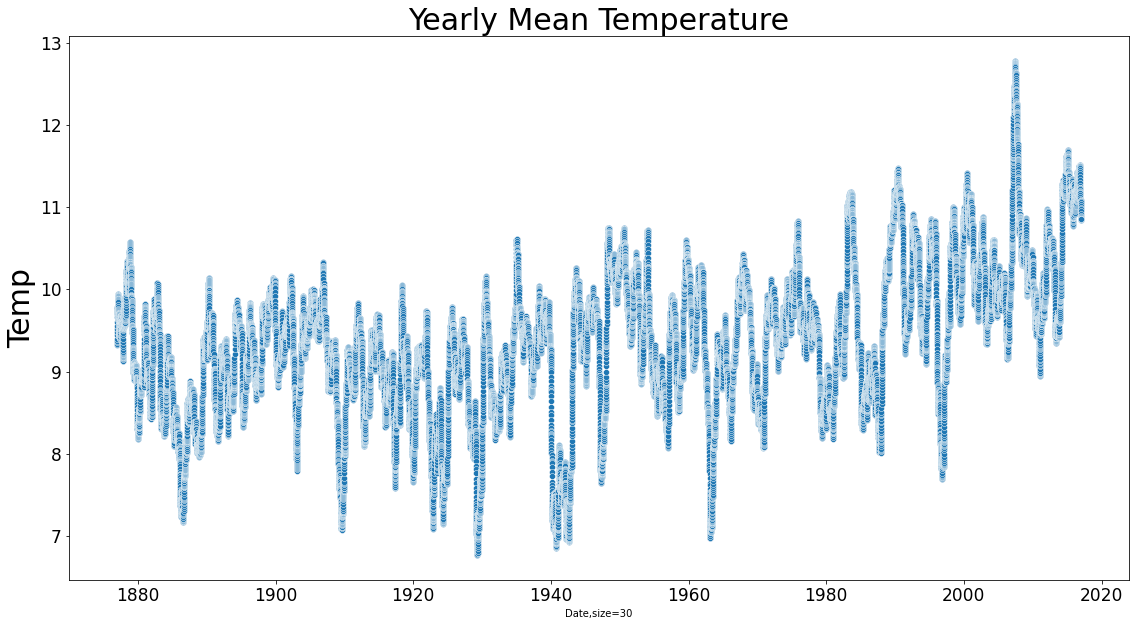

In [1294]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df_train.loc[:'2020-12-31'].rolling(365).mean(), y ='T', x ='DATE')
plt.ylabel('Temp',size=30)
plt.xlabel('Date,size=30')
plt.title('Yearly Mean Temperature',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

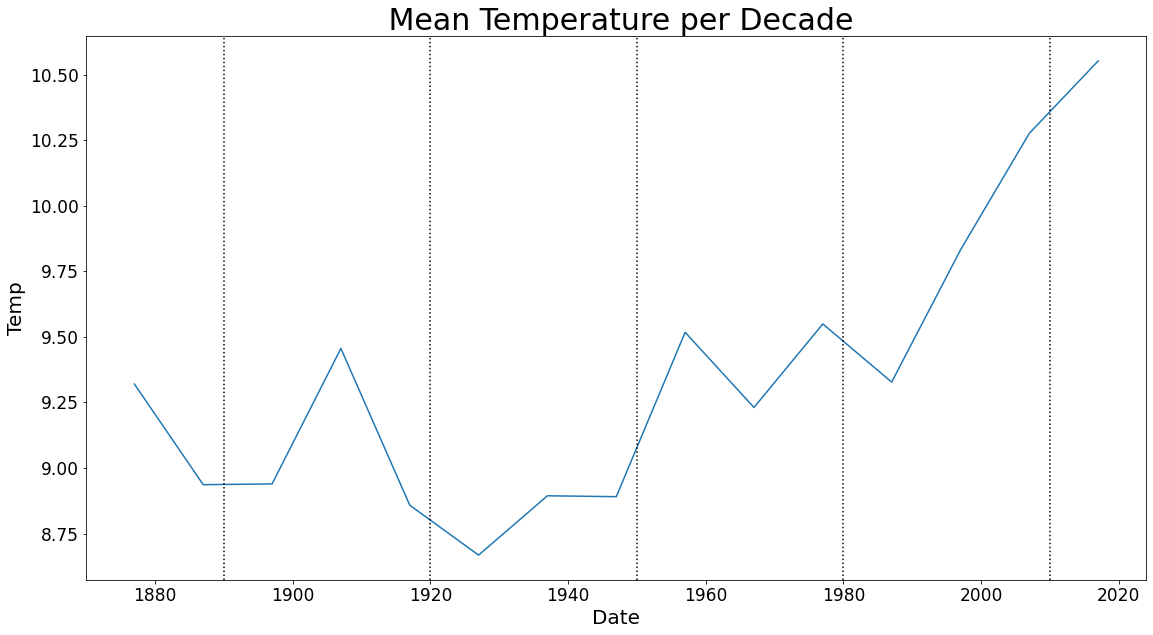

In [1295]:
plt.figure(figsize=(19,10))
sns.lineplot(data =df_train.loc[:'2020-12-31'].resample('10Y').mean(), y ='T', x ='DATE')
plt.ylabel('Temp',size=20)
plt.xlabel('Date',size=20)
mod = [y for y in df_train.index.year if not y%30]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.title(' Mean Temperature per Decade',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
plt.show()

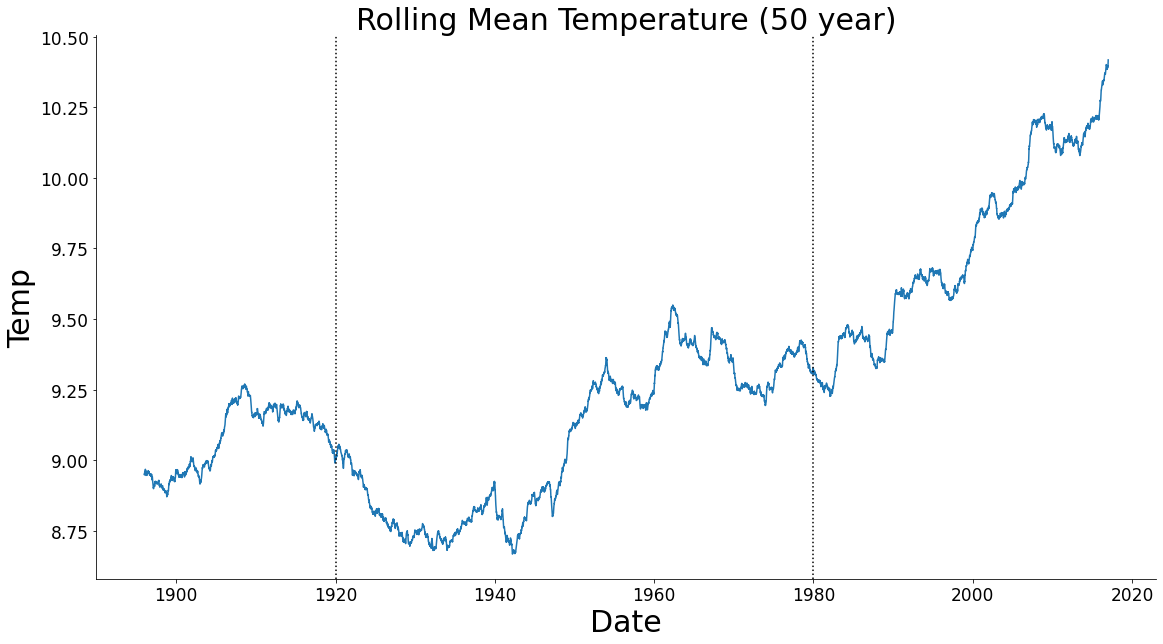

In [1296]:
import datetime as dt
plt.figure(figsize=(19,10))
sns.lineplot(data = df_train.rolling(2*3652).mean(), y ='T', x ='DATE', markersize=12)
mod = [y for y in df_train.index.year if not y%60]
for year in set(mod):
   plt.axvline(datetime.datetime(year, 1, 1), color='black', ls=':')
plt.ylabel('Temp',size=30)
plt.xlabel('Date',size=30)
plt.title('Rolling Mean Temperature (50 year)',size=30)
plt.xticks(size=17)
plt.yticks(size=17)
sns.despine()

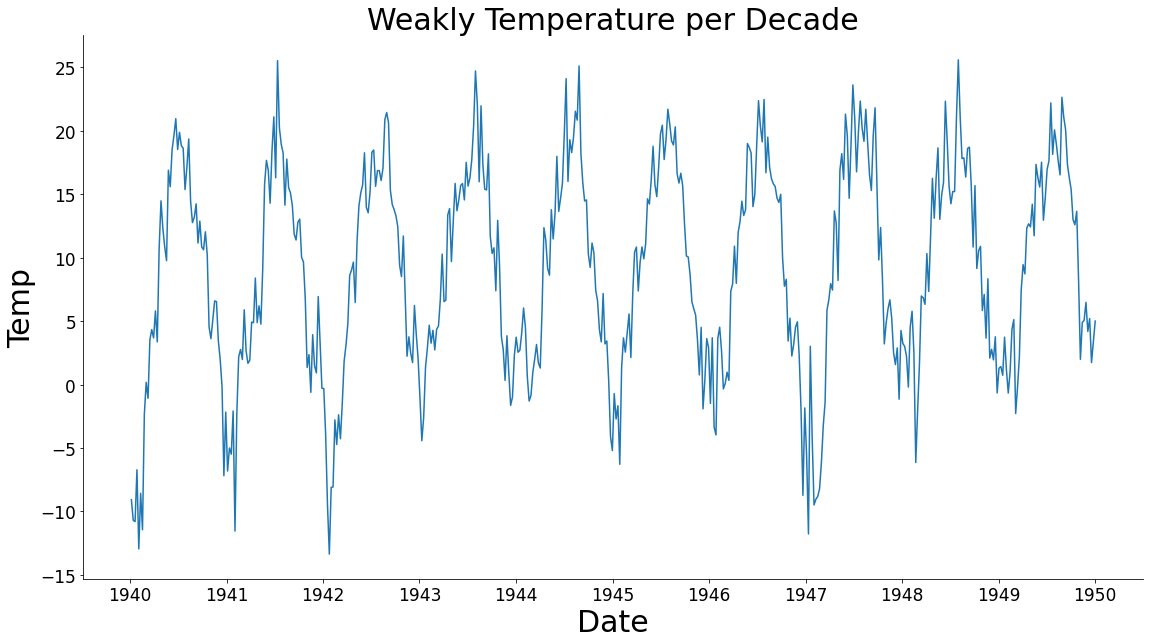

In [1297]:
mod = list(set([y for y in df_train.index.year if not y%10]))
for decade in random.sample(mod[:-2],1):
    plt.figure(figsize=(19,10))
    start = f'{decade}-01-01'
    end = f'{decade+9}-12-31'
    sns.lineplot(data = df_train['T'].loc[start:end].resample('W').mean())
    plt.title('Weakly Temperature per Decade',size=30)
    plt.ylabel('Temp',size=30)
    plt.xlabel('Date',size=30)  
    plt.xticks(size=17)
    plt.yticks(size=17)
    sns.despine()

# Cycles of climate? 

### Most important: Yearly Orbit around the Sun

Solar activity: 
  * multiples of 22.75 years
  * intensity increase slowly and then decrease sharply, with a period of about 80-100 years

Ocean-atmosphere interactions: 
 1. El Niño-Southern Oscillation (ENSO): 
  * an interaction between ocean temperatures and atmospheric patterns 
  * 3 to 7 
  * years different weather conditions to different parts of the world (NASA 2009)

2. Pacific Decadal Oscillation (PDO): 
  * occurs in cycles of 25-45 years (Mantua et al. 1997), 

3. Atlantic Multi-decadal Oscillation (AMO):
  * occurring on approximately 65-85 year cycles (Deser et al. 2010). 
  * interaction with the enhanced greenhouse effect (Li et al. 2013).

### Non periodic effects

Orbit around the Sun:
  * changes in eccentricity
  * changes in the tilt of the earth's axis

Random events:
  * Volcanos
  * meteorites
  * comets

Human:
  * Greenhouse gases
  * industrial pollution particles
  * ozone depletion


source:  
 * https://www.fs.usda.gov/ccrc/education/climate-primer/natural-climate-cycles
 * http://dmod.physics.auth.gr/klima_02.htm
 

# Fast Fourier Transform

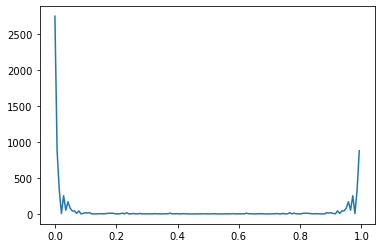

In [1298]:
n = len(df_train.resample('Y').mean())
# fast fourier transform
TG_hat = np.fft.fft(df['T'],n)
# power spectral density
psd = TG_hat * np.conj(TG_hat)/n
# frequency in years
freq =np.arange(n)/n
plt.plot(freq,np.absolute(psd))
None

/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_23945/1778279381.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/freq,np.absolute(psd))


(1.2, 60.0)

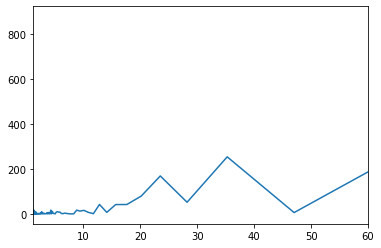

In [1299]:
plt.plot(1/freq,np.absolute(psd))
plt.xlim(1.2,60)

In [1300]:
for n,p in np.ndenumerate(psd):
    if n[0]==0: continue
    if (np.absolute(p)>100):
        print(p,141/n[0])

(879.8267278223099+0j) 141.0
(333.80036388174466+0j) 70.5
(254.17930781469192+0j) 35.25
(169.15490204637754+0j) 23.5
(169.15490204637754+0j) 1.0444444444444445
(254.17930781469192+0j) 1.0291970802919708
(333.8003638817446+0j) 1.014388489208633
(879.8267278223099+0j) 1.0071428571428571


# Creating dummy variables

I will create one or yearly periodicity with monthly resolution and one for the ~60 year (not so normal) cycles

In [1301]:
df_train

,T
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8
...,...
2016-12-27,6.3
2016-12-28,6.1
2016-12-29,4.1


In [1302]:
df_train['timestep'] = list(range(len(df_train)))
df_train

,T,timestep
DATE,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4
...,...,...
2016-12-27,6.3,51495
2016-12-28,6.1,51496
2016-12-29,4.1,51497


In [1303]:
df_train['timestep^2'] = df_train['timestep']**2
df_train

,T,timestep,timestep^2
DATE,,,
1876-01-01,2.2,0,0
1876-01-02,2.5,1,1
1876-01-03,0.3,2,4
1876-01-04,-5.8,3,9
1876-01-05,-9.8,4,16
...,...,...,...
2016-12-27,6.3,51495,2651735025
2016-12-28,6.1,51496,2651838016
2016-12-29,4.1,51497,2651941009


In [1304]:
df_train['cycle_1'] = df_train.index.month
df_train['cycle_2'] = df_train.index.year%24
df_train['cycle_3'] = df_train.index.year%36
df_train.columns

Index(['T', 'timestep', 'timestep^2', 'cycle_1', 'cycle_2', 'cycle_3'], dtype='object')

In [1305]:
X_train_fe = df_train.drop('T', axis=1)
y_train = df_train['T']

In [1306]:
X_train_fe = pd.get_dummies(X_train_fe, columns=['cycle_1', 'cycle_2', 'cycle_3'], drop_first=True, )

In [1307]:
X_train_fe

,timestep,timestep^2,cycle_1_2,cycle_1_3,cycle_1_4,cycle_1_5,cycle_1_6,cycle_1_7,cycle_1_8,cycle_1_9,...,cycle_3_26,cycle_3_27,cycle_3_28,cycle_3_29,cycle_3_30,cycle_3_31,cycle_3_32,cycle_3_33,cycle_3_34,cycle_3_35
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,51495,2651735025,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-28,51496,2651838016,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-29,51497,2651941009,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1308]:
y_train

DATE
1876-01-01    2.2
1876-01-02    2.5
1876-01-03    0.3
1876-01-04   -5.8
1876-01-05   -9.8
             ... 
2016-12-27    6.3
2016-12-28    6.1
2016-12-29    4.1
2016-12-30    0.3
2016-12-31    0.8
Name: T, Length: 51500, dtype: float64

In [1309]:
m = LinearRegression()
m.fit(X_train_fe, y_train)
df_train['seasonal_trend'] = m.predict(X_train_fe)
m.score(X_train_fe, y_train)

0.7555348200336239

<AxesSubplot:xlabel='DATE'>

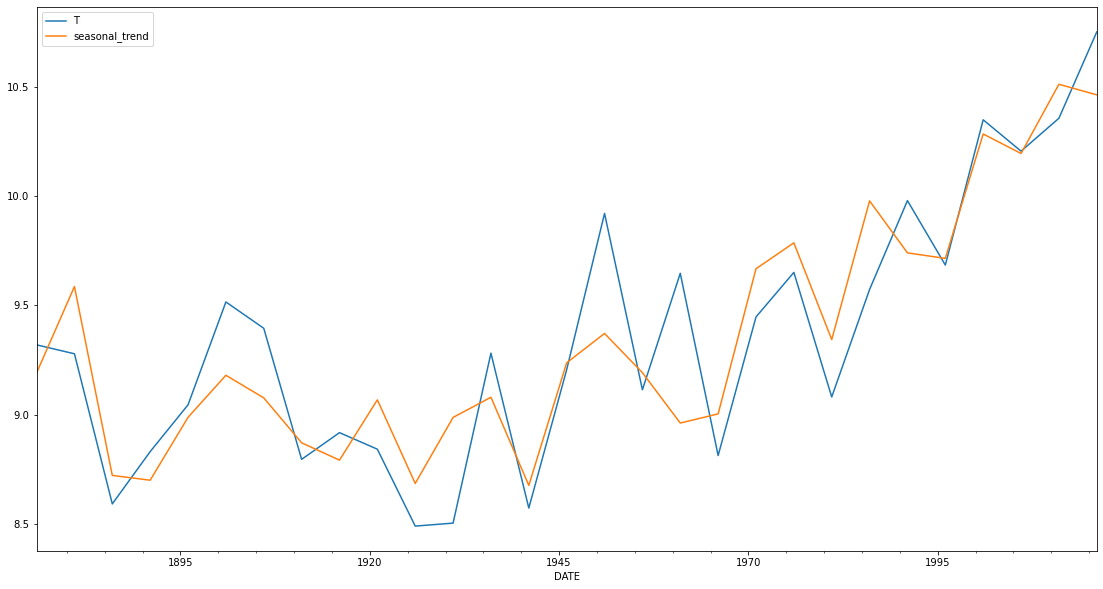

In [1310]:
df_train[['T', 'seasonal_trend']].resample('5Y').mean().plot(figsize=(19,10))

In [1311]:
df_train['remainder']=df_train['T']-df_train['seasonal_trend']

<AxesSubplot:xlabel='DATE'>

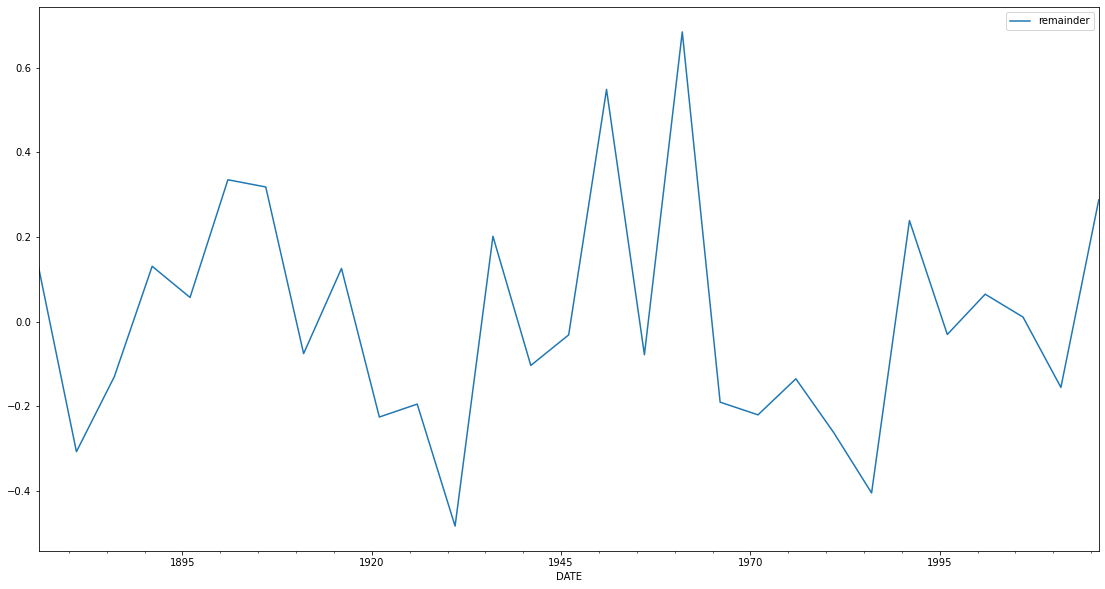

In [1312]:
df_train[['remainder']].resample('5Y').mean().plot(figsize=(19,10))

Text(0, 0.5, 'Partial Autocorrelation')

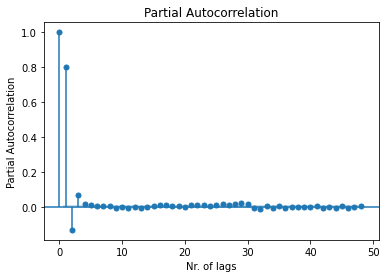

In [1313]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train['remainder']);
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')

In [1314]:
X_train_fe['lag1'] = df_train['remainder'].shift(1)
X_train_fe['lag2'] = df_train['remainder'].shift(2)
X_train_fe['lag3'] = df_train['remainder'].shift(3)

In [1315]:
X_train_fe

,timestep,timestep^2,cycle_1_2,cycle_1_3,cycle_1_4,cycle_1_5,cycle_1_6,cycle_1_7,cycle_1_8,cycle_1_9,...,cycle_3_29,cycle_3_30,cycle_3_31,cycle_3_32,cycle_3_33,cycle_3_34,cycle_3_35,lag1,lag2,lag3
DATE,,,,,,,,,,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1876-01-02,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.412931,NaN,NaN
1876-01-03,2,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.712968,2.412931,NaN
1876-01-04,3,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.513004,2.712968,2.412931
1876-01-05,4,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-5.586959,0.513004,2.712968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,51495,2651735025,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5.731866,4.931961,2.032056
2016-12-28,51496,2651838016,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.631771,5.731866,4.931961
2016-12-29,51497,2651941009,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3.431676,3.631771,5.731866


In [1316]:
X_train_fe.dropna(inplace=True)

In [1317]:
y_train[3:]


DATE
1876-01-04   -5.8
1876-01-05   -9.8
1876-01-06   -7.7
1876-01-07   -6.6
1876-01-08   -8.9
             ... 
2016-12-27    6.3
2016-12-28    6.1
2016-12-29    4.1
2016-12-30    0.3
2016-12-31    0.8
Name: T, Length: 51497, dtype: float64

In [1318]:
m.fit(X_train_fe, y_train[3:])
df_train['pred_full'] = 0
df_train['pred_full'][3:] = m.predict(X_train_fe)

/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_23945/2655587621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pred_full'][3:] = m.predict(X_train_fe)


<AxesSubplot:xlabel='DATE'>

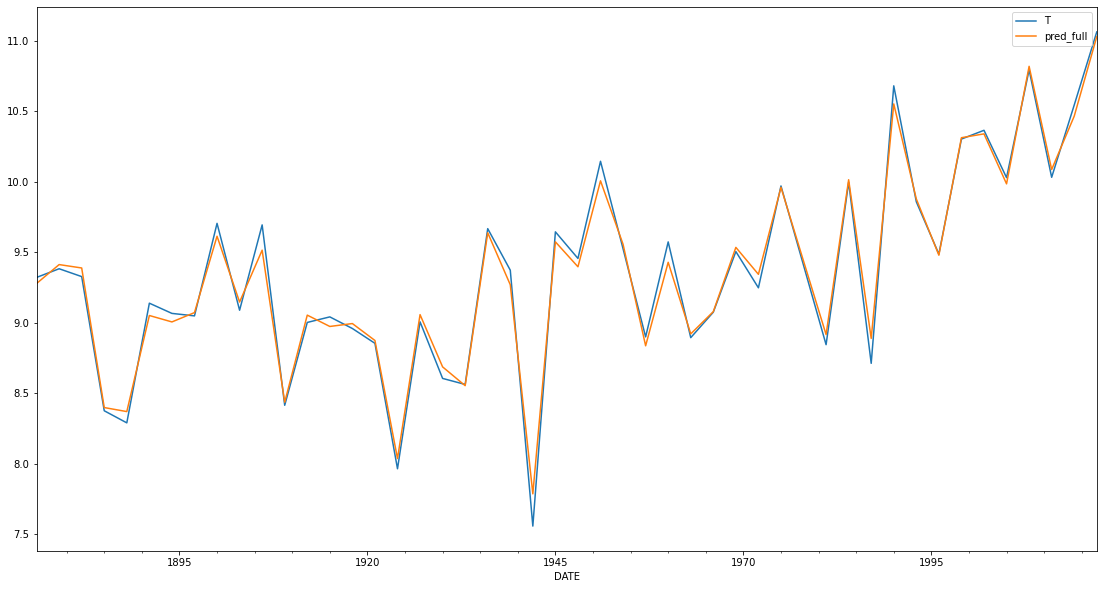

In [1319]:
df_train[['T', 'pred_full']].resample('3Y').mean().plot(figsize=(19,10))

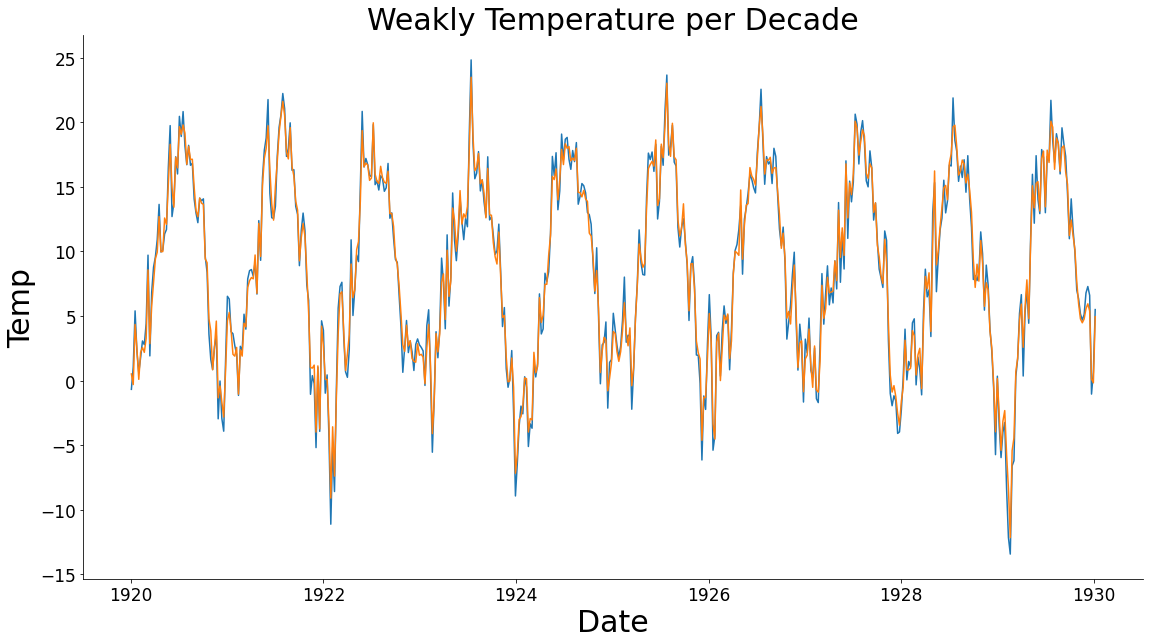

In [1320]:
mod = list(set([y for y in df_train.index.year if not y%10]))
for decade in random.sample(mod[:-2],1):
    plt.figure(figsize=(19,10))
    start = f'{decade}-01-01'
    end = f'{decade+9}-12-31'
    sns.lineplot(data = df_train['T'].loc[start:end].resample('W').mean())
    sns.lineplot(data = df_train['pred_full'].loc[start:end].resample('W').mean())
    plt.title('Weakly Temperature per Decade',size=30)
    plt.ylabel('Temp',size=30)
    plt.xlabel('Date',size=30)  
    plt.xticks(size=17)
    plt.yticks(size=17)
    sns.despine()

In [1321]:
df_test['timestep'] = list(range(len(df_test)))
df_test['timestep^2'] = df_test['timestep']**2
df_test['cycle_1'] = df_test.index.month
df_test['cycle_2'] = df_test.index.year%24
df_test['cycle_3'] = df_test.index.year%36

In [1322]:
X_test_fe = df_test.drop('T', axis=1)
y_test = df_test['T']

In [1323]:
X_test_fe = pd.get_dummies(X_test_fe, columns=['cycle_1', 'cycle_2', 'cycle_3'], drop_first=True, )
X_test_fe

,timestep,timestep^2,cycle_1_2,cycle_1_3,cycle_1_4,cycle_1_5,cycle_1_6,cycle_1_7,cycle_1_8,cycle_1_9,...,cycle_2_2,cycle_2_3,cycle_2_4,cycle_2_5,cycle_2_6,cycle_3_2,cycle_3_3,cycle_3_4,cycle_3_5,cycle_3_6
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-02,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-03,2,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-04,3,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-05,4,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27,1852,3429904,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2022-01-28,1853,3433609,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2022-01-29,1854,3437316,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [1324]:
m.fit(X_test_fe, y_test)
df_test['seasonal_trend'] = m.predict(X_test_fe)
df_test['remainder']=df_test['T']-df_test['seasonal_trend']

In [1325]:
X_test_fe['lag1'] = df_test['remainder'].shift(1)
X_test_fe['lag2'] = df_test['remainder'].shift(2)
X_test_fe['lag3'] = df_test['remainder'].shift(3)

In [1326]:
X_test_fe.dropna(inplace=True)

In [1327]:
m.fit(X_test_fe, y_test[3:])
df_test['pred_full'] = 0
df_test['pred_full'][3:] = m.predict(X_test_fe)

/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_23945/1295338678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_full'][3:] = m.predict(X_test_fe)


<AxesSubplot:xlabel='DATE'>

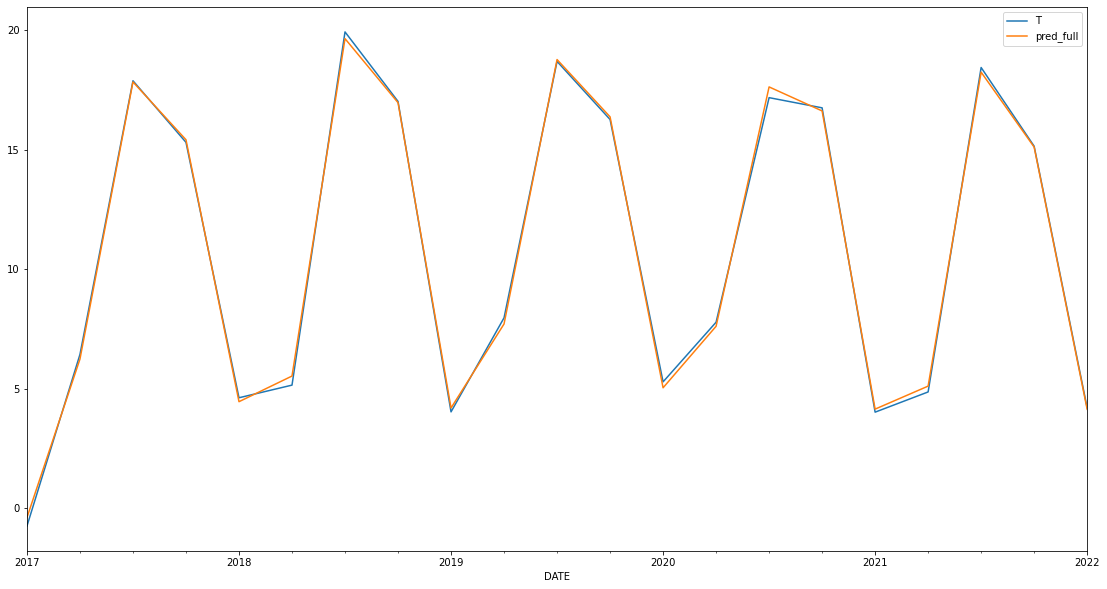

In [1328]:
df_test[['T', 'pred_full']].resample('3M').mean().plot(figsize=(19,10))

<AxesSubplot:xlabel='DATE'>

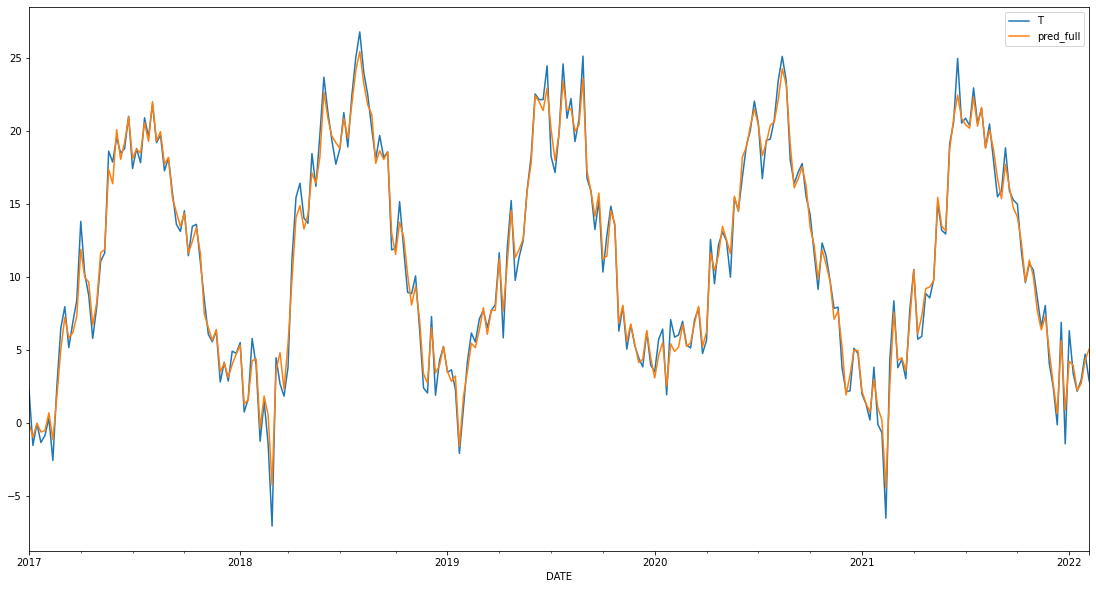

In [1329]:
df_test[['T', 'pred_full']].resample('W').mean().plot(figsize=(19,10))

<AxesSubplot:xlabel='DATE'>

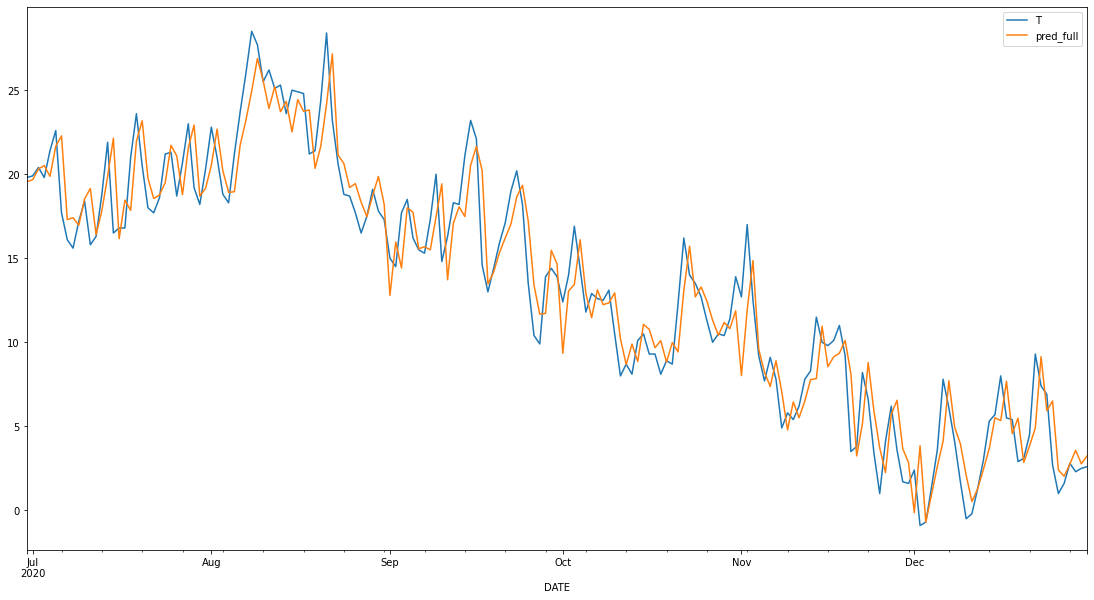

In [1340]:
n = df_test.loc['2020-06-30':'2020-12-31']
n[['T', 'pred_full']].plot(figsize=(19,10))

In [1330]:
from sklearn.metrics import r2_score
r2_score(df_test['T'],df_test['pred_full'])

0.9206723439912071

In [1331]:
r2_score(df_train['T'],df_train['pred_full'])

0.9140865408222518